In [97]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from matplotlib.gridspec import GridSpec


FACTOR = 1.2
SMALL_SIZE = 8 * FACTOR
MEDIUM_SIZE = 11 * FACTOR
BIGGER_SIZE = 14 * FACTOR

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
#plt.rc('figure', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('figure',autolayout=True)
plt.rc('lines', linewidth=2)
plt.rc('lines', markersize=7)

# fix rcParams for plotting
#plt.rcParams.update({'title.font.size': 14})
#plt.rcParams.update({'lines.linewidth': 2, 'lines.markersize': 10})


In [98]:
data = pd.read_csv('../data/data-agg.csv')

data['N_throws'] = data['N_start_heads_up'] + data['N_start_tails_up']
data['tails_tails'] = data['N_start_tails_up'] - data['tails_heads']
data['heads_tails'] = data['N_start_heads_up'] - data['heads_heads']
data['same_side'] = data['heads_heads'] + data['tails_tails']

# drop ingeborgR
data = data[data['person']!='ingeborgR'] # -> adds both a person and a coin (100 throws, can remove her)

data['failures'] = data['N_throws'] - data['same_side']

In [ ]:
def deviance_analysis( data, formula ):
    model = smf.glm(formula=formula, data=data, family=sm.families.Binomial())
    results = model.fit()
    dic = {}
    dic['formula'] = formula
    dic['deviance'] = results.deviance
    dic['aic'] = results.aic
    dic['df_residual'] = results.df_resid
    dic['df_model'] = results.df_model

    return dic, results



def compare_lr_test( results, results_restricted ):
    deviance_diff = results_restricted.deviance - results.deviance
    df_diff = results_restricted.df_resid - results.df_resid
    p_value = 1 - stats.chi2.cdf(deviance_diff, df_diff)
    return p_value



formula_cst = 'same_side + failures ~ 1'
formula_person = 'same_side + failures ~ 1 + C(person)'
formula_coin_pers = 'same_side + failures ~ 1 + C(person) + C(coin)'

results = []
dic_cst, results_cst = deviance_analysis(data, formula_cst)
results.append(dic_cst)
dic_person, results_person = deviance_analysis(data, formula_person)
results.append(dic_person)
dic_coin_pers, results_coin_pers = deviance_analysis(data, formula_coin_pers)
results.append(dic_coin_pers)
results_df = pd.DataFrame(results)

#print(results_df)

print('Table for model comparison : \n')
string = results_df.to_latex(index=False, 
                columns=["formula", "deviance", "aic", "df_model"], 
                header=["Model", "Deviance", "AIC", "Model DF"],
                formatters={"formula": lambda x: r'\texttt{'+x+r'}'},
                float_format="{:.2f}".format,
                caption="Model comparison for different models",
                label="tab:model-comparison",
                position="htb",
                column_format="lccc")
string = string.replace('_', '\\_')
string = string.replace('~', '$\\sim$')
print(string)

print( f'Testing {dic_person['formula']} against {dic_cst['formula']} : ')
print( f'p-value : {compare_lr_test( results_coin_pers, results_person ):.2e}' )
print( f'Testing {dic_coin_pers['formula']} against {dic_person['formula']} : ')
print( f'p-value : {compare_lr_test( results_coin_pers, results_cst ):.2e}' )


Table for model comparison : 

\begin{table}[htb]
\caption{Model comparison for different models}
\label{tab:model-comparison}
\begin{tabular}{lccc}
\toprule
Model & Deviance & AIC & Model DF \\
\midrule
\texttt{same\_side + failures $\sim$ 1} & 483.45 & 2076.00 & 0 \\
\texttt{same\_side + failures $\sim$ 1 + C(person)} & 217.47 & 1902.02 & 46 \\
\texttt{same\_side + failures $\sim$ 1 + C(person) + C(coin)} & 151.08 & 1919.63 & 88 \\
\bottomrule
\end{tabular}
\end{table}

Testing same_side + failures ~ 1 + C(person) against same_side + failures ~ 1 : 
p-value : 9.61e-03
Testing same_side + failures ~ 1 + C(person) + C(coin) against same_side + failures ~ 1 + C(person) : 
p-value : 0.00e+00


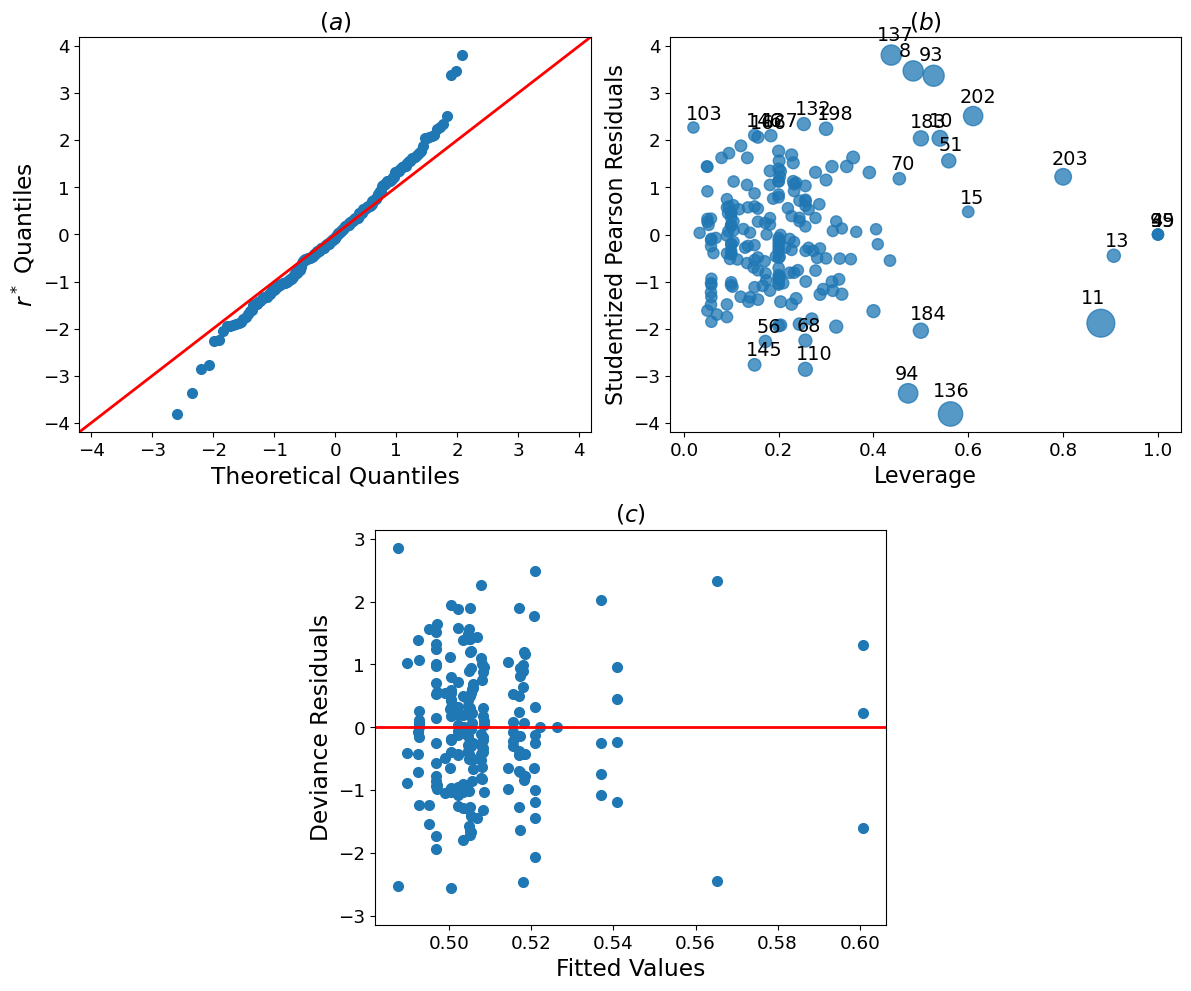

In [100]:
# can add plot of residuals vs fitted values/linear predictor or covariates
# can also plot cook statitcs

def influence_analysis( results, ax ):
    influence_inst = results.get_influence()
    leverage = influence_inst.hat_matrix_diag

    resid_dev = results.resid_deviance / np.sqrt(1-leverage)
    resid_pea = results.resid_pearson / np.sqrt(1-leverage)
    
    influence = {}
    influence['dav_resid'] = resid_dev + np.log( resid_pea / resid_dev ) / resid_dev
    influence['stud_pea_resid'] = influence_inst.resid_studentized
    influence['leverage'] = leverage
    influence['cooks_d'] = influence_inst.cooks_distance

    sm.qqplot(influence['dav_resid'], line ='45', ax=ax[0])
    #sm.qqplot(influence['stud_pea_resid'], line ='45', ax=ax[1])
    ax[0].set_ylabel('$r^*$ Quantiles')
    ax[0].set_title('$(a)$')
    influence_inst.plot_influence(size=20, ax=ax[1])
    ax[1].set_title('$(b)$')
    ax[1].set_ylabel('Studentized Pearson Residuals')

    return influence

fig = plt.figure(figsize=(12, 10))

gs = GridSpec(2, 4, figure=fig)
ax1 = fig.add_subplot(gs[0,0:2])
ax2 = fig.add_subplot(gs[0,2:])
ax3 = fig.add_subplot(gs[1,1:-1])

influence = influence_analysis( results_person, [ax1,ax2] )

fitted = results_person.fittedvalues
residuals = results_person.resid_deviance
ax3.scatter( fitted, residuals )
ax3.axhline(0, color='red')
max_resid = max(np.abs(residuals))
ax3.set_ylim(-1.1*max_resid, 1.1*max_resid)
ax3.set_xlabel('Fitted Values')
ax3.set_ylabel('Deviance Residuals')
ax3.set_title('$(c)$')

plt.savefig('../figures/GLM_diagnostics.png', dpi=300)



In [28]:
# import data
data = pd.read_csv('../data/full-coin-data/coin data/analyses/data-long.csv' )#, nrows=100000)
# print number of rows and columns
print(data.shape)
# print type of data
# if toss_start = toss_end, set new column same_side = 1
data['same_side'] = 0
data['same_side'] = np.where(data['toss_start'] == data['toss_end'], 1, 0)
print(data.head())
print(data.dtypes)




(350757, 7)
       person          coin   dataset  sequence_id  toss_id toss_start  \
0  frantisekB  20DEM-silver  Marathon            1        1          t   
1  frantisekB  20DEM-silver  Marathon            1        2          t   
2  frantisekB  20DEM-silver  Marathon            1        3          t   
3  frantisekB  20DEM-silver  Marathon            1        4          h   
4  frantisekB  20DEM-silver  Marathon            1        5          t   

  toss_end  same_side  
0        t          1  
1        t          1  
2        h          0  
3        t          0  
4        h          0  
person         object
coin           object
dataset        object
sequence_id     int64
toss_id         int64
toss_start     object
toss_end       object
same_side       int64
dtype: object


KeyboardInterrupt: 

In [22]:

formula = 'same_side ~ 1 + C(coin) + C(person)'
mod1 = smf.glm(formula=formula, data=data, family=sm.families.Binomial()).fit()
print(mod1.summary())
# could play with link


                 Generalized Linear Model Regression Results                  
Dep. Variable:              same_side   No. Observations:               100000
Model:                            GLM   Df Residuals:                    99968
Model Family:                Binomial   Df Model:                           31
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -69268.
Date:                Mon, 23 Dec 2024   Deviance:                   1.3854e+05
Time:                        16:22:05   Pearson chi2:                 1.00e+05
No. Iterations:                   100   Pseudo R-squ. (CS):          0.0006420
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [12]:
family = sm.families.Binomial( ) 
glm = sm.GLM( data['same_side'], data[['person','coin']], family=family)
res = glm.fit()
print(res.summary())

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).